In [34]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

pd.set_option('display.max_columns', None)

In [35]:
gl_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-Game-Log.csv')
gl_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Game-Log.csv')
gl_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Game-Log.csv')
gl_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Game-log.csv')
gl_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Game-Log.csv')

team_opp_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-PerGameTeamAndOpponentStats.csv')
team_opp_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Team&Opponent-Per-Game.csv')
team_opp_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Team&Opp-Per-Game.csv')
team_opp_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Team&Opponents.csv')
team_opp_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Team&Opp-Per-Game.csv')

roster_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-roster.csv')
roster_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Roster.csv')
roster_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Roster.csv')
roster_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Roster.csv')
roster_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Roster.csv')

In [36]:
all_gl = pd.concat([gl_19_20, gl_20_21, gl_21_22, gl_22_23, gl_23_24], ignore_index=True)
all_gl = all_gl.drop(columns=['Unnamed: 0', 'G', 'OT', 'Streak'])
all_gl

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Result,PF,PA,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF.1,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2019-11-05,8:00p,REG,Nicholls State,NaN,False,Southland,-3.87,W,78,70,1,0,True,1.0,0.0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2019-11-08,9:00p,REG,Grand Canyon,NaN,False,WAC,-6.32,W,83,71,2,0,False,2.0,0.0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2019-11-10,9:00p,REG,Arizona,21.0,True,Pac-12,19.49,L,69,90,2,1,False,0.0,1.0,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2019-11-18,8:00p,REG,Hawaii,NaN,False,Big West,-1.27,W,66,53,3,1,True,1.0,0.0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2019-11-20,9:00p,REG,The Citadel,NaN,False,Southern,-13.82,W,85,57,4,1,True,2.0,0.0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2024-03-17,8:30p,REG,Purdue,NaN,False,Big Ten,24.93,L,78,83,11,3,False,0.0,1.0,30,57,0.526,7,20,0.350,26,30,0.867,11,35,14,2,5,9,19,30,64,0.469,7,20,0.350,20,23,0.870,10,25,17,7,1,7,20
182,2024-03-21,9:00p,REG,Michigan State,NaN,False,Big Ten,17.72,W,71,68,12,3,True,1.0,0.0,32,59,0.542,12,26,0.462,9,12,0.750,9,36,24,5,7,9,9,26,65,0.400,11,30,0.367,6,8,0.750,6,25,14,7,0,6,13
183,2024-03-23,2:00p,REG,Maryland,NaN,False,Big Ten,10.60,L,67,76,12,4,True,0.0,1.0,35,59,0.593,7,21,0.333,12,17,0.706,10,31,17,6,1,7,12,25,61,0.410,5,17,0.294,8,10,0.800,12,25,14,4,1,9,17
184,2024-03-28,8:30p,REG,Michigan,NaN,False,Big Ten,5.28,W,88,73,13,4,False,1.0,0.0,24,57,0.421,9,29,0.310,15,29,0.517,12,37,16,8,2,11,18,23,58,0.397,6,13,0.462,17,21,0.810,5,32,9,11,3,9,23


/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_1510/2465919298.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])


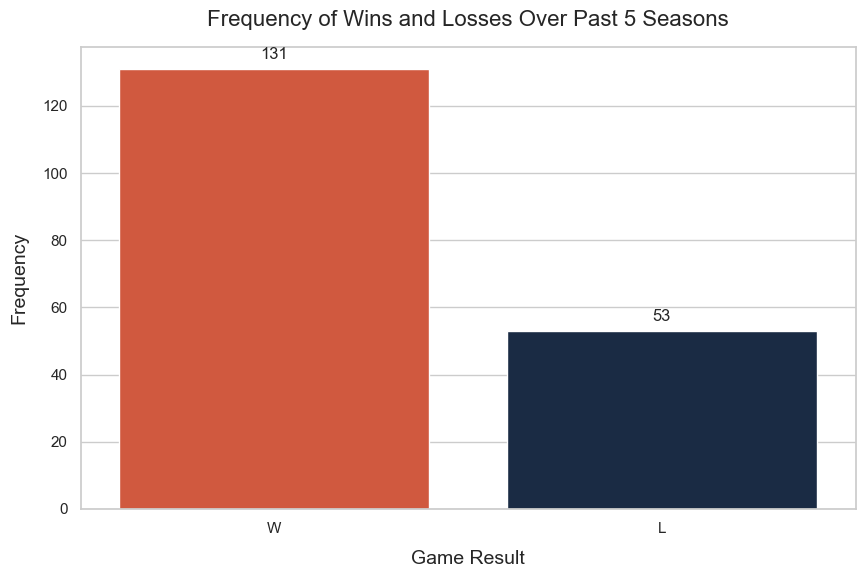

In [37]:
# Recalculate the result counts
result_counts = all_gl['Result'].value_counts().reset_index()
result_counts.columns = ['Result', 'Frequency']

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.title('Frequency of Wins and Losses Over Past 5 Seasons', fontsize=16, pad=15)

# Adding value annotations on top of the bars
for index, row in result_counts.iterrows():
    plt.text(row.name, row.Frequency + 2, row.Frequency, ha='center', va='bottom', fontsize=12)

plt.show()
